In [1]:
from evoman.environment import Environment
from demo_controller import player_controller

import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy import stats
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.6.0 (SDL 2.28.4, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## box plot

In [27]:
'''
def find_best_solution(enemy_group, method):
    print(f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt')
    file_name = f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt'
    best_files = glob.glob(file_name)
    best_fitness = -np.inf
    best_solution = None

    for file in best_files:
        sol = np.loadtxt(file)
        fitness, _, _, _ = env.play(sol)
        
        if fitness > best_fitness:
            best_solution = sol

    return best_solution

'''

"\ndef find_best_solution(enemy_group, method):\n    print(f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt')\n    file_name = f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt'\n    best_files = glob.glob(file_name)\n    best_fitness = -np.inf\n    best_solution = None\n\n    for file in best_files:\n        sol = np.loadtxt(file)\n        fitness, _, _, _ = env.play(sol)\n        \n        if fitness > best_fitness:\n            best_solution = sol\n\n    return best_solution\n\n"

In [11]:
def extract_all_sols(enemy_group, method):
   
    #
    main_dir = f'experiments_train_generalist_{enemy_group}'
    sols_list = []

    #
    for subdir in os.listdir(main_dir):
        # 
        if subdir.startswith(f'optimization_generalist_generalist_{method}'):
            best_file_path = os.path.join(main_dir, subdir, 'best.txt')
            
            # check if the file exist
            if os.path.exists(best_file_path):
                try:
                
                    sol = np.loadtxt(best_file_path)
                    sols_list.append(sol)
                except Exception as e:
                    print(f"mistake")
            else:
                print(f"not exist")

   
    return sols_list

In [17]:
n_hidden_neurons = 10

env = Environment(experiment_name='best_experiment_test',
                multiplemode="yes",
                playermode="ai",
				player_controller=player_controller(n_hidden_neurons),
				speed="fastest",
				enemymode="static",
                logs="off",
                randomini="yes",
				level=2,
				visuals=True)

results = {}
method_list = ['GA1', 'GA2']
enemy_groups = ['1_3_4_6', '2_5_7_8']


for enemy_group in enemy_groups:
    for method in method_list:
        
        env.update_parameter('enemies', [1,2,3,4,5,6,7,8])
        #sol = find_best_solution(enemy_group, method)
        sol_list = extract_all_sols(enemy_group, method)
        individual_gain_list = []
        for sol in sol_list:
            
            _, player_life, enemy_life, _=env.play(sol)
            indivdual_gain=player_life-enemy_life
            individual_gain_list.append(indivdual_gain)
        
        results[(enemy_group, method)] = individual_gain_list

In [18]:
results 

{('1_3_4_6', 'GA1'): [-36.569683630685944,
  -12.595287017902194,
  -41.62172645978974,
  -46.02795775857756,
  -16.98585128400994,
  -35.361564389082645,
  -22.602447323271765,
  -34.18495902779323,
  -26.86457279389645,
  -18.653943200150305],
 ('1_3_4_6', 'GA2'): [-22.144053569882843,
  -12.77329705980977,
  -25.291978814856368,
  -10.827231975385985,
  -19.393182722377716,
  -31.229353807824562,
  -21.563019495432112,
  -20.6224325300073,
  -4.1622382367333906,
  -6.526065958915872],
 ('2_5_7_8', 'GA1'): [-12.581214575788795,
  -11.412137498380961,
  -24.00319482239632,
  -15.566430405566365,
  -29.278007213287008,
  1.0367616957333539,
  -24.31402015328928,
  1.3852297296442906,
  -6.341453803582304,
  -38.99925260664297],
 ('2_5_7_8', 'GA2'): [-9.792737688423436,
  -0.848329324691381,
  -1.4044435371588193,
  -16.405265748748675,
  -4.22207549501579,
  -19.225782447146536,
  -21.117427109094553,
  -15.06480685208889,
  -21.842031063670746,
  -9.10792988285122]}

{'whiskers': [<matplotlib.lines.Line2D at 0x218d01d8d30>,
 'caps': [<matplotlib.lines.Line2D at 0x218d01d81f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x218d01d88e0>,
 'medians': [<matplotlib.lines.Line2D at 0x218d0936430>,
 'fliers': [<matplotlib.lines.Line2D at 0x218d09369d0>,
 'means': []}

Text(0.5, 1.0, 'Boxplot of Gain Values')

Text(0, 0.5, 'Individual Gain')

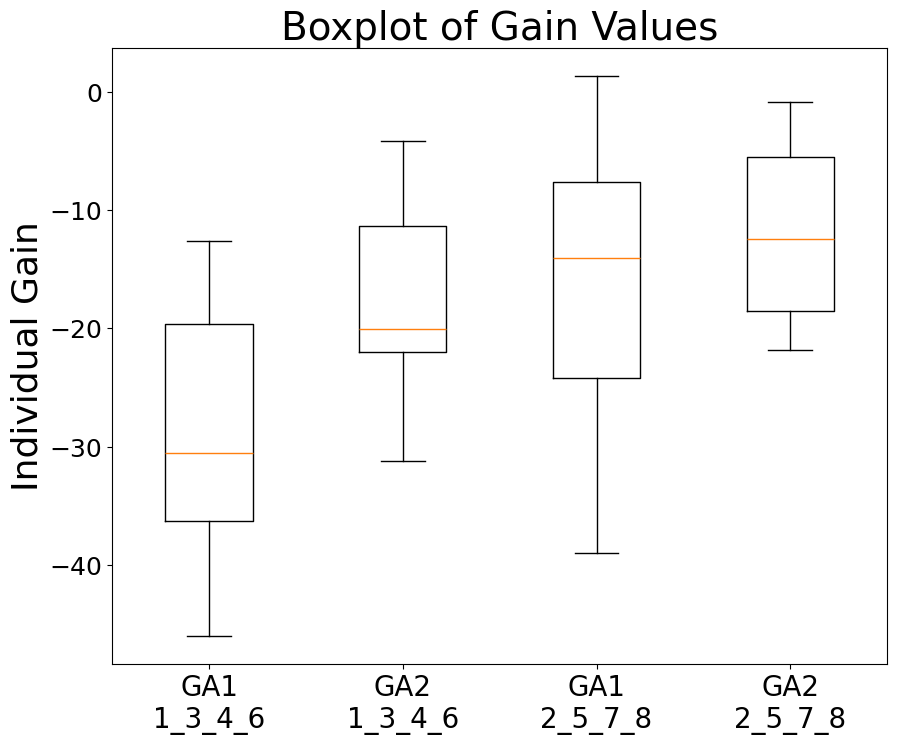

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
data = [results[key] for key in sorted(results.keys())]
labels = [f"{e}\n{m}" for m, e in sorted(results.keys())]

ax.boxplot(data, labels=labels)
ax.set_title('Boxplot of Gain Values', fontsize=28)
ax.set_ylabel('Individual Gain', fontsize=26)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=18)
# plt.xticks(rotation=45)
plt.savefig("box_plot_2.png", dpi=150)

In [20]:
# Mann-Whitney U test
alpha = 0.05
mannwhitney_results = {}

for enemy_group in enemy_groups:
    ga_results = results[(enemy_group, 'GA1')]
    es_results = results[(enemy_group, 'GA2')]

    u_stat, p_value = stats.mannwhitneyu(ga_results, es_results, alternative='two-sided')
    mannwhitney_results[enemy_group] = {'u_stat': u_stat, 'p_value': p_value}


for enemy_group, res in mannwhitney_results.items():
    print(f"Enemy {enemy_group} - U statistic: {res['u_stat']:.3f}, p-value: {res['p_value']:.3e}")
    if res['p_value'] < alpha:
        print(f"For Enemy {enemy_group}, the difference between GA and ES is statistically significant.")
    else:
        print(f"For Enemy {enemy_group}, no significant difference was found.")

Enemy 1_3_4_6 - U statistic: 22.000, p-value: 3.764e-02
For Enemy 1_3_4_6, the difference between GA and ES is statistically significant.
Enemy 2_5_7_8 - U statistic: 41.000, p-value: 5.205e-01
For Enemy 2_5_7_8, no significant difference was found.


In [21]:
# t-test
ttest_results = {}

for enemy_group in enemy_groups:
    ga_results = results[(enemy_group, 'GA1')]
    es_results = results[(enemy_group, 'GA2')]

    t_stat, p_value = stats.ttest_ind(ga_results, es_results, equal_var=False)
    ttest_results[enemy_group] = {'t_stat': t_stat, 'p_value': p_value}

for enemy_group, res in ttest_results.items():
    print(f"Enemy {enemy_group} - t-statistic: {res['t_stat']:.3f}, p-value: {res['p_value']:.3e}")
    if res['p_value'] < alpha:
        print(f"For Enemy {enemy_group}, the difference between GA and ES is statistically significant.")
    else:
        print(f"For Enemy {enemy_group}, no significant difference was found.")

Enemy 1_3_4_6 - t-statistic: -2.611, p-value: 1.837e-02
For Enemy 1_3_4_6, the difference between GA and ES is statistically significant.
Enemy 2_5_7_8 - t-statistic: -0.844, p-value: 4.121e-01
For Enemy 2_5_7_8, no significant difference was found.


In [22]:
# Kolmogorov-Smirnov test
ks_results = {}

for enemy_group in enemy_groups:
    ga_results = results[(enemy_group, 'GA1')]
    es_results = results[(enemy_group, 'GA2')]

    ks_stat, p_value = stats.ks_2samp(ga_results, es_results)
    ks_results[enemy_group] = {'ks_stat': ks_stat, 'p_value': p_value}

for enemy_group, res in ks_results.items():
    print(f"Enemy {enemy_group} - KS statistic: {res['ks_stat']:.3f}, p-value: {res['p_value']:.3e}")

Enemy 1_3_4_6 - KS statistic: 0.500, p-value: 1.678e-01
Enemy 2_5_7_8 - KS statistic: 0.400, p-value: 4.175e-01


In [23]:
# Kruskal-Wallis H test
kruskal_results = {}

for enemy_group in enemy_groups:
    ga_results = results[(enemy_group, 'GA1')]
    es_results = results[(enemy_group, 'GA2')]

    h_stat, p_value = stats.kruskal(ga_results, es_results)  
    kruskal_results[enemy_group] = {'h_stat': h_stat, 'p_value': p_value}

for enemy_group, res in kruskal_results.items():
    print(f"Enemy {enemy_group} - H statistic: {res['h_stat']:.3f}, p-value: {res['p_value']:.3e}")

    if res['p_value'] < alpha:
        print(f"For Enemy {enemy_group}, the difference between GA and ES is statistically significant.")
    else:
        print(f"For Enemy {enemy_group}, no significant difference was found.")

Enemy 1_3_4_6 - H statistic: 4.480, p-value: 3.429e-02
For Enemy 1_3_4_6, the difference between GA and ES is statistically significant.
Enemy 2_5_7_8 - H statistic: 0.463, p-value: 4.963e-01
For Enemy 2_5_7_8, no significant difference was found.


## Very Best

In [24]:
n_hidden_neurons = 10

env = Environment(experiment_name='best_experiment_test',
                multiplemode="yes",
                playermode="ai",
				player_controller=player_controller(n_hidden_neurons),
				speed="fastest",
				enemymode="static",
                logs="off",
                randomini="yes",
				level=2,
				visuals=True)

results = {}
method_list = ['GA1', 'GA2']
enemy_groups = ['1_3_4_6', '2_5_7_8']

best_gain = -np.inf
best_solution = None
best_file_name = None

for enemy_group in enemy_groups:
    for method in method_list:
        print(f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt')
        file_name = f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt'
        best_files = glob.glob(file_name)   
        
        for file in best_files:
            sol = np.loadtxt(file)
            env.update_parameter('enemies', [1,2,3,4,5,6,7,8])
            _, player_life, enemy_life, _ = env.play(sol)
            avg_gain = player_life - enemy_life
        
            if avg_gain > best_gain:
                best_gain = avg_gain
                best_solution = sol
                best_file_name = file

experiments_train_generalist_1_3_4_6/optimization_generalist_generalist_GA1_*/best.txt
experiments_train_generalist_1_3_4_6/optimization_generalist_generalist_GA2_*/best.txt
experiments_train_generalist_2_5_7_8/optimization_generalist_generalist_GA1_*/best.txt
experiments_train_generalist_2_5_7_8/optimization_generalist_generalist_GA2_*/best.txt


In [26]:
print(best_file_name)
print(best_solution)

experiments_train_generalist_2_5_7_8\optimization_generalist_generalist_GA2_20241018-010746\best.txt
[ 0.60073388 -0.41015465 -0.34048379  0.8499766   0.54825643 -0.51304915
  0.80801077  0.58199113 -0.03025086 -0.61121154 -0.16059245  0.05584901
 -0.63380917 -0.29272197 -0.64622068 -0.50323254  1.06269787 -0.76968373
  0.20923829 -0.03071445  0.61402263 -0.23858193 -0.74275213 -0.94824459
 -0.63787967  0.70778841  0.70914373 -0.67788664 -1.1222797  -0.75428394
 -0.39563242  0.88892244 -1.03093239  0.24970824  0.3212386   0.68802388
  0.66450102  0.51399998 -0.78695888  0.96842698 -0.32123133  0.02481327
  0.77406604 -0.20225889 -0.2988722   0.07065422  0.88267641 -0.80398555
  0.54539511 -0.40382234 -0.62695361  0.44016969 -0.31627284  0.68957389
  0.90342199 -0.10138107  0.49415511 -0.00235002 -0.62585548 -0.95380905
  0.11325297 -0.30240758 -0.75787337  0.62558542  0.36692001 -0.96469453
  0.30088635 -0.49866204 -0.9044345   0.43762006 -1.01884475 -0.60347194
  0.37978055 -0.7493134

In [10]:
print(best_file_name)

experiments_train_generalist_1_3_4_6/optimization_generalist_generalist_GA1_20241017-182533/best.txt


In [28]:
n_hidden_neurons = 10

env = Environment(experiment_name='best_experiment_test',
                playermode="ai",
				player_controller=player_controller(n_hidden_neurons),
				speed="fastest",
				enemymode="static",
                logs="off",
                randomini="yes",
				level=2,
				visuals=True)


individual_gain_list = []


for i in range(1,9):
    
    env.update_parameter('enemies', [i])
    _, player_life, enemy_life, _ = env.play(best_solution)
    individual_gain = int(player_life - enemy_life)
    individual_gain_list.append(individual_gain)

print(individual_gain_list)

[-90, 56, -60, -80, 55, -100, 37, 52]
